In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import kagglehub
import os

# --- Constantes (mesmas de antes) ---
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
BATCH_SIZE = 32

# 1. Baixa o dataset
print("Baixando o dataset...")
base_download_path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")
print(f"Dataset baixado para: {base_download_path}")

# 2. PROCURAR o caminho certo
# Vamos procurar pela pasta que contém as 6 classes (ex: 'cardboard', 'glass')
correct_path = None
for dirpath, dirnames, filenames in os.walk(base_download_path):
    # Verifica se as pastas das classes estão DENTRO do diretório atual
    if 'cardboard' in dirnames and 'glass' in dirnames and 'metal' in dirnames:
        correct_path = dirpath # Encontramos!
        break

# 3. Definir o caminho final
if correct_path:
    path = correct_path
    print(f"\n--- SUCESSO! ---")
    print(f"O caminho correto para o gerador é: {path}")
    print(f"Conteúdo deste caminho (deve ter 6 pastas): {os.listdir(path)}")
else:
    # Caso a lógica falhe, tentamos o caminho base (o que estávamos fazendo)
    path = base_download_path
    print(f"\n--- ATENÇÃO ---")
    print("Não foi possível encontrar as subpastas automaticamente.")
    print(f"Tentando usar o caminho base: {path}")
    print(f"Conteúdo do caminho base: {os.listdir(path)}")

Baixando o dataset...
Dataset baixado para: C:\Users\korea\.cache\kagglehub\datasets\asdasdasasdas\garbage-classification\versions\2

--- SUCESSO! ---
O caminho correto para o gerador é: C:\Users\korea\.cache\kagglehub\datasets\asdasdasasdas\garbage-classification\versions\2\Garbage classification\Garbage classification
Conteúdo deste caminho (deve ter 6 pastas): ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [3]:
# Configura o Data Augmentation para o gerador de treino
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normaliza os pixels (0-1)
    rotation_range=20,      # Rotação
    zoom_range=0.2,         # Zoom
    horizontal_flip=True,   # Inversão horizontal
    fill_mode='nearest',
    validation_split=0.2    # Separa 20% para validação
)

# O gerador de validação/teste só precisa normalizar os pixels
test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Deve ser o mesmo split
)

In [4]:
# Gerador de TREINO (usa data augmentation)
train_generator = train_datagen.flow_from_directory(
    directory=path,
    target_size=IMG_SIZE,       # <--- MUDANÇA: Usa 224x224
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',          # Define como conjunto de treino
    shuffle=True
)

# Gerador de VALIDAÇÃO (não usa data augmentation)
validation_generator = test_datagen.flow_from_directory(
    directory=path,
    target_size=IMG_SIZE,       # <--- MUDANÇA: Usa 224x224
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',        # Define como conjunto de validação
    shuffle=False               # Importante: False para matriz de confusão
)

# Imprime as classes encontradas
print(f"Classes encontradas: {train_generator.class_indices}")

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Classes encontradas: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [5]:
model = Sequential()

# --- Bloco 1 ---
# Especificação de Entrada: (224, 224, 3)
model.add(Input(shape=IMG_SHAPE))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- Bloco 2 ---
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- Bloco 3 ---
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# --- Classificador ---
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) # Dropout para evitar overfitting

# --- Camada de Saída ---
# Especificação de Saída: 6 neurônios com softmax
model.add(Dense(6, activation='softmax'))

# Exibe o resumo do modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,399,174 (169.37 MB)

 Trainable params: 44,399,174 (169.37 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
# Define um número de épocas (ex: 20)
EPOCHS = 20

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 696ms/step - accuracy: 0.3238 - loss: 1.8231 - val_accuracy: 0.3833 - val_loss: 1.6057
Epoch 2/20
 1/63 ━━━━━━━━━━━━━━━━━━━━ 33s 544ms/step - accuracy: 0.3125 - loss: 1.6784

c:\Users\korea\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.3125 - loss: 1.6784 - val_accuracy: 0.3625 - val_loss: 1.4921
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 707ms/step - accuracy: 0.4493 - loss: 1.3584 - val_accuracy: 0.4417 - val_loss: 1.3382
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4375 - loss: 1.1971 - val_accuracy: 0.4271 - val_loss: 1.3494
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 680ms/step - accuracy: 0.5176 - loss: 1.2446 - val_accuracy: 0.4396 - val_loss: 1.3834
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5000 - loss: 1.2160 - val_accuracy: 0.4604 - val_loss: 1.3684
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 677ms/step - accuracy: 0.5602 - loss: 1.1435 - val_accuracy: 0.4729 - val_loss: 1.3740
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5938 - loss: 1.0782 - val_accuracy: 0.4625 - val_loss: 1.3723
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 703ms/step - accuracy: 0.5934 - loss: 1.0639 - val_accuracy: 0.5146 - val_

In [10]:
best_score = max(history.history['val_accuracy'] )
print(f"Best Validation score is: {best_score}")

Best Validation score is: 0.606249988079071


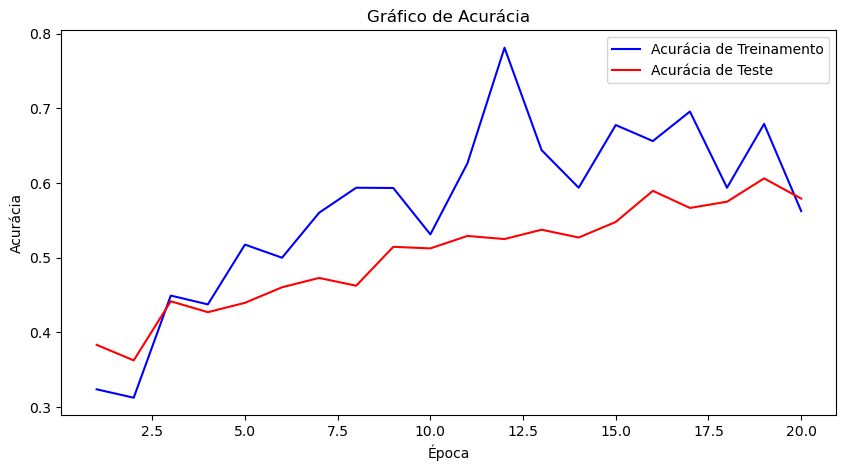

In [13]:
# Accuracy on train data :
accuracy = history.history['accuracy']

# Accuracy on test data :
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)  # Epochs

# Accuracy line plot :
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'b', label='Acurácia de Treinamento')
plt.plot(epochs, val_accuracy, 'r', label='Acurácia de Teste')
plt.title('Gráfico de Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend();


--- Avaliação Final no Conjunto de Validação ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5606 - loss: 1.2328
Acurácia de Validação: 56.06%
Loss de Validação: 1.2328

--- Gerando Matriz de Confusão ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step


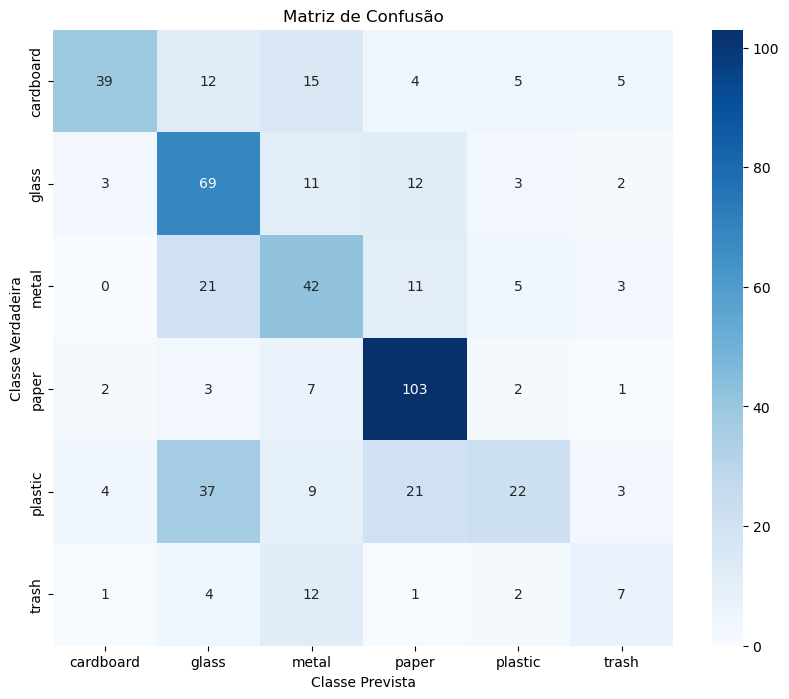

In [8]:
# 1. Avaliar a Acurácia Categórica final
print("\n--- Avaliação Final no Conjunto de Validação ---")
scores = model.evaluate(validation_generator)
print(f"Acurácia de Validação: {scores[1] * 100:.2f}%")
print(f"Loss de Validação: {scores[0]:.4f}")

# 2. Gerar a Matriz de Confusão
print("\n--- Gerando Matriz de Confusão ---")

# Obter as previsões
# (Usamos o validation_generator que já está com shuffle=False)
y_pred_probs = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Obter os rótulos verdadeiros
true_classes = validation_generator.classes

# Obter os nomes das classes
class_labels = list(validation_generator.class_indices.keys())

# Calcular a Matriz
cm = confusion_matrix(true_classes, y_pred_classes)

# Plotar a Matriz
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()